In [4]:
import sys
stdout = sys.stdout

In [5]:
import numpy as np
import os
from scipy import ndimage, misc
import matplotlib.pyplot as plt
#from skimage.io import imread
from skimage.color import rgb2gray
%matplotlib inline
from EMAN2 import *

In [6]:
from __future__ import print_function
from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
import tensorflow as tf

In [7]:
#import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras import backend as K
from skimage.exposure import rescale_intensity
from skimage import io
import matplotlib

In [9]:
import matplotlib.patches as mpatches
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.morphology.selem import disk
import cv2
from skimage.filters import gaussian
from skimage.feature import peak_local_max, blob_log
#from scipy import ndimage
from skimage import morphology
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
#from skimage import data, color

/var/folders/fn/nlgx_qdn2r19y90q6x372b3c0000gn/T/ipykernel_29248/2318367190.py:4: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


Helper function
###############


In [10]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    data = data - mean
    data = data/std
    return data

In [11]:
def pred_accuracy(test_labels,pred_labels):
    acc = []
    for i in range((test_labels.shape[0])):
        acc.append(dice_coef(test_labels[i].astype('float64'),pred_labels[i]).numpy().astype('float64'))
    return (np.average(acc))

In [12]:
def stack_outfile(*dats, outfile):
    im_x,im_y = dats[0].shape[1:]
    out_array = np.array([*zip(*dats)]).reshape(-1,im_x,im_y)
    #print(out_array.shape)
    out = from_numpy(out_array)
    out.write_image(outfile)

In [13]:
def hist_plot(history):
    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs

In [14]:
def plot_bbox(im,im_label):
    im_label_overlay = label2rgb(im_label,image=im,bg_label=0,image_alpha=0.5)
    fig, ax = plt.subplots()
    ax.imshow(im_label_overlay)

    for region in (regionprops(im_label)):
        print(region.bbox)
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,fill=False,edgecolor='blue',linewidth=1)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [15]:
def plot_comparison(im1, im2, im1_name="",im2_name=""):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(im1, cmap=plt.cm.gray)
    ax1.set_title(im1_name)
    ax1.axis('off')
    ax2.imshow(im2, cmap=plt.cm.gray)
    ax2.set_title(im2_name)
    ax2.axis('off')
 

In [16]:
def plot_dataset(data_arr,lab_arr,ind_arr=None,nrow=8,ncol=8):
    class_names = ['Background','Alpha','Dense']
    #class_names = ['Dense','Alpha']
    plt.figure(figsize=(ncol*2,nrow*2))
    if ind_arr == None:
        ind_arr = np.random.choice(len(lab_arr),nrow*ncol,replace=False)
    else:
        ind_arr = ind_arr
    print(ind_arr)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data_arr[ind_arr[i]].squeeze(), cmap='gray')
        plt.xlabel(class_names[int(lab_arr[ind_arr[i]])])
        #plt.xlabel((lab_arr[ind_arr[i]]))
    plt.show()   

In [17]:
def rescale_dataset(data_array,rescale_size=None,interpolation_med=cv2.INTER_CUBIC):    
    data_rescale = []
    for im in data_array.squeeze():
        temp=cv2.resize(im, dsize=rescale_size, interpolation=interpolation_med)
        data_rescale.append(temp)
    return np.asarray(data_rescale,dtype=np.float32)

Load data from hdf file from boxer tools.

In [18]:
def load_particles(ptcls,labelshrink=1,ncopy=1, rng=None):
    if rng==None:
        rng=random
    #num=old_div(EMUtil.get_image_count(ptcls),2)
    #print(num)
    is3d=False
    e=EMData(ptcls,0, True)
    tsz=max(e["nx"],e["ny"])
    
    nframe=EMUtil.get_image_count(ptcls)
    if nframe==1:
        nframe=e["nz"]
        if nframe>1:
            is3d=True
    num = nframe//2
    data=[]
    label=[]
    ntrain=-1
    
    for i in range(num):
        for nc in range(ncopy):
            if is3d:
                ptl=EMData(ptcls,0, False,Region(0,0,i*2,tsz,tsz,1))
            else:
                ptl=EMData(ptcls,i*2, False, Region(0,0,tsz,tsz))
                           
            if ntrain<0 and ptl.get_attr_default("valid_set", 0)==1:
                ntrain=len(data)
            #ptl.process_inplace("threshold.belowtozero")
            if ncopy>1:
                tr=Transform()
                tr.set_rotation({"type":"2d","alpha":rng.random()*360.0})
                ptl.process_inplace("xform",{"transform":tr})
            ar=ptl.numpy().copy()
            #shp=np.shape(ar)
            data.append(ar)
            
            if is3d:
                ptl=EMData(ptcls,0, False,Region(0,0,i*2+1,tsz,tsz,1))
            else:
                ptl=EMData(ptcls,i*2+1, False, Region(0,0,tsz,tsz))
            #ptl.process_inplace("threshold.belowtozero")
                           
            if ncopy>1:
                ptl.process_inplace("xform",{"transform":tr})
            if labelshrink>1:
                ptl.process_inplace("math.meanshrink",{'n':int(labelshrink)})
            ar=ptl.numpy().copy()
            #shp=np.shape(ar)
            label.append(ar)

    if ntrain<0: ntrain=len(data)
    print("{:d} particles loaded, {:d} in training set, {:d} in validation set".format(len(data), ntrain, len(data)-ntrain))
    data=np.asarray(data,dtype=np.float32)  
    print(data.shape)
    print("Std of particles: ",np.std(data))
    #data/=np.std(data.flatten())*3  #np.max(np.abs(data))
    data/=3. ### so the range is roughly (-1,1)
    label=np.asarray(label,dtype=np.float32)
    label/=(np.max(np.abs(label)))  
    header=EMData(ptcls,0,True)
    shape=[header["nx"],header["ny"],header["nz"]]
    return data, label, shape, ntrain

8992 particles loaded, 8992 in training set, 0 in validation set
(8992, 32, 32)
Std of particles:  1.4064252


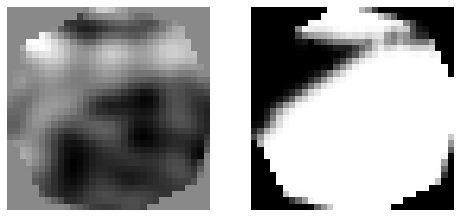

In [46]:
#load train data. Input is a trainset.hdf file from the boxertools.
datas, labels, shape, ntrain=load_particles('./particles/dense_256_smallreg_data_raw_trainset.hdf',1,ncopy=2)
#reshape data to 4-d tensor
datas=normalize(datas).reshape((-1, 32, 32, 1))
plot_comparison(datas[100].squeeze(),labels[100])
#dataset = tf.data.Dataset.from_tensor_slices((datas, labels))
#dataset=dataset.shuffle(500).batch(10)

In [20]:
#calculate metric and loss
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) )
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [21]:
#u-net
def get_unet(inp_x=None,inp_y=None):
    inputs = Input((inp_x, inp_y, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    #up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [22]:
m = get_unet(32,32)
m.summary()

2023-01-31 14:36:55.896018: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [23]:
from tensorflow.python.keras.metrics import Metric
def train_unet(train_data, label_data,weights_out,pretrained = None,no_epoch = 5, batch_sz= 10,val_split=0.2,learnrate=1e-4):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    #model = get_unet_small()
    if pretrained != None:
        model.load_weights(pretrained)
    model.compile(optimizer=Adam(learning_rate=learnrate), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer='sgd',loss='mse',metrics=[Metric.BinaryIoU(target_class_id=[1], threshold=0.5)])
    model_checkpoint = ModelCheckpoint(weights_out, monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(train_data, label_data, batch_size=batch_sz, epochs=no_epoch, verbose=1, shuffle=True,
              validation_split=val_split,
              callbacks=[model_checkpoint])
    return model,history

In [35]:
#train the model
model, hist = train_unet(datas[0:500],labels[0:500],batch_sz=50,weights_out='weights_dense_small_withbg_test.h5',val_split=0.1,no_epoch = 
                            10,learnrate=1e-3)

------------------------------
Loading and preprocessing train data...
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/10
9/9 [==============================] - 9s 816ms/step - loss: -0.5005 - dice_coef: 0.5005 - val_loss: -0.5755 - val_dice_coef: 0.5755
Epoch 2/10
9/9 [==============================] - 7s 786ms/step - loss: -0.5971 - dice_coef: 0.5971 - val_loss: -0.5933 - val_dice_coef: 0.5933
Epoch 3/10
9/9 [==============================] - 7s 787ms/step - loss: -0.6354 - dice_coef: 0.6354 - val_loss: -0.6760 - val_dice_coef: 0.6760
Epoch 4/10
9/9 [==============================] - 7s 774ms/step - loss: -0.8061 - dice_coef: 0.8061 - val_loss: -0.7832 - val_dice_coef: 0.7832
Epoch 5/10
9/9 [==============================] - 7s 768ms/step - loss: -0.8123 - dice_coef: 0.8123 - val_loss: -0.8048 - val_dice_coef: 0.8048
Epoch 6/10
9/9 [==============================] - 7s 789ms/step - l

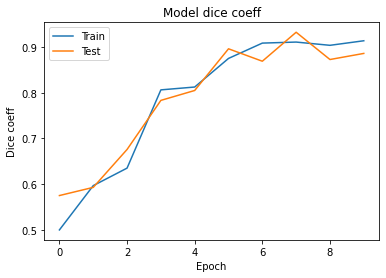

In [36]:
#plot model learning curves
hist_plot(hist)

In [37]:
#load model for prediction and applying
def load_model(weights_in):
    model = get_unet()
    #model = get_unet_small()
    #model = get_unet_23()
    model.load_weights(weights_in)
    #model.summary()
    return model

In [38]:
def predict_unet(test_data, test_labels,weights_in,test_label_outfile=None,pred_dir=None):
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model = load_model(weights_in)
    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_label_test = model.predict(test_data, verbose=1)
    #print(model.evaluate(test_data,test_labels))
    if test_label_outfile:   
        np.save(test_label_outfile, imgs_label_test)
        print('-' * 30)
        print('Saving predicted masks to files...')
        print('-' * 30)
    if pred_dir:  
        if not os.path.exists(pred_dir):
            os.mkdir(pred_dir)
        for k in range(len(imgs_label_test)):  
            a=rescale_intensity(test_data[k][:,:,0],out_range=(-1,1))
            b=(imgs_label_test[k][:,:,0]).astype('uint8')
            io.imsave(os.path.join(pred_dir, str(k) + '_pred.png'),mark_boundaries(a,b))
    return imgs_label_test
        
            #Saving our predictions in the directory 'pred_dir'
    

In [39]:
#load test data
test_data,test_label,shape,ntrain = load_particles('dense_256.hdf',1,ncopy=1)

1335 particles loaded, 1335 in training set, 0 in validation set
(1335, 256, 256)
Std of particles:  0.86517984


In [41]:
#predict label on test data
predicted = predict_unet(test_data[0:100], test_label[0:100],weights_in='weights_dense_small_withbg_test.h5')

------------------------------
Loading and preprocessing test data...
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
4/4 [==============================] - 15s 3s/step


In [42]:
#write the test data, label and predicted stack to hdf5 to visualize in EMAN2
stack_outfile(test_data.squeeze(),test_label,predicted.squeeze(),outfile="dense_train_on_small_withbg_test.hdf")

In [43]:
#apply the trained unet on a tomogram
def apply_unet(weights_in=None,tomogram=None,outfile=None):
    if tomogram==None:
        print("Need to specify tomogram to apply U-net")
        return
    if weights_in==None:
        print("Need to provide weights of U-net")
        return
    model = load_model(weights_in)
    
    nframe=EMUtil.get_image_count(tomogram)
    is3d=False
    ### deal with 3D volume or image stack
    e=EMData(tomogram, 0, True)
    apix=e["apix_x"]
    if nframe==1:
        nframe=e["nz"]
        if nframe>1:
        #### input data is 3D volume
            is3d=True

    enx,eny=e["nx"], e["ny"]
    tsz=max(enx,eny)

    output=EMData(e["nx"], e["ny"], nframe)
    output["tomogram_src"]=tomogram
    #output["nnet_src"]=options.from_trained
    output["apix_x"]=apix
    output["apix_y"]=apix
    output["apix_z"]=apix

    print("Loading tomogram...")
    tomo_in=[]
    for nf in range(nframe):
        if is3d:          
            e0=EMData(tomogram, 0, False, Region((enx-tsz)//2,(eny-tsz)//2,nf,tsz,tsz,1))
        else:
            e0=EMData(tomogram, nf, False, Region((enx-tsz)//2,(eny-tsz)//2,tsz,tsz))
        tomo_in.append(e0)
    print(len(tomo_in))
    for idx, img in enumerate(tomo_in):
        if idx == 123:
            plt.imshow(tomo_in[idx].numpy())
        m=img.numpy()
        p=model.predict(m[None, :, :, None]/3.,verbose=1)
        #p[p<0]=0
        cout=from_numpy(p[0,:,:,0])
        cout=cout.get_clip(Region((cout["nx"]-enx)//2,(cout["ny"]-eny)//2 ,enx, eny))
        #cout.scale(int(options.labelshrink))
        output.insert_clip(cout, [0,0,idx])

        sys.stdout.write("\r  {}/{} finished.".format(idx+1, len(tomo_in)))
        sys.stdout.flush()
    if outfile:
        output.write_image(outfile)
    return output

In [44]:
#save np segment map
def save_segment_map(weights_in=None,tomogram=None,outfile=""):
    output = apply_unet(weights_in,tomogram)
    c_out = to_numpy(output) 
    print(c_out.shape())
    np.save(outfile, c_out)

In [45]:
#apply trained unet on tomogram
outmap = apply_unet(weights_in='weights_dense_small_withbg_test.h5',tomogram='set24_tomo.hdf',
                    outfile='set24_tomo__test_seg.hdf')

Loading tomogram...
10
1/1 [==============================] - 2s 2s/step
  10/10 finished.